# ***seismo-at-school*: RaspberryShake Switzerland - Seismogramme**

Diese Webanwendung ermöglicht Dir, auf die Daten aller RaspberryShake Schulsensoren in der Schweiz zuzugreifen und Seismogramme darstellen. Sie wurde im Rahmen des *seismo-at-school* Projektes am Schweizerischen Erdbebendienst ([SED](http://seismo.ethz.ch/de/home/)) an der ETH Zürich in Zusammenarbeit mit der Universität Lausanne ([UNIL](https://www.unil.ch/index.html)) und dem Centre Pédagogique Prévention Séisme ([CPPS](https://www.cpps-vs.ch/home)) in Sion entwickelt.

Um den nachfolgenden Code auszuführen, gehe zunächst auf die Menuleiste oben und klicke unter Menupunkt **Run** auf **Run All Cells**. Du solltest nach etwa einer Minute unterhalb der Code-Zellen Ergebnisse sehen. Du kannst Parameter, wie zum Beispiel ein Erdbeben oder einen RaspberryShake, selbst auswählen und den Code erneut ausführen, um die Seismogramme darzustellen. **Klicke dazu auf die jeweilige Zelle und dann auf den Pfeil im Menu oben.** Code-Zellen können auch einzeln ausgeführt werden. Falls Du schon etwas Python programmieren kannst, kannst Du den Code auch selbst verändern oder erweitern.


Lade zunächst ein paar Bibliotheken und Variablen, die der Code benötigt.

In [1]:
# @title  { display-mode: "form" }
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:

# Install/Load libraries:
import warnings
warnings.filterwarnings("ignore")
try:
    import obspy
except:
    !pip install obspy | grep -v 'already satisfied'

try:
    import cartopy
except:
    !pip install cartopy | grep -v 'already satisfied'

from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime, Stream, Trace, Stats
from obspy.taup import TauPyModel
from obspy.geodetics import gps2dist_azimuth
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import widgets, interact, Dropdown, Select


# Earthquake search:
options_year=[("2023",0),("2024",1)]
function_year = widgets. Dropdown (
  options=options_year,
  value=1,
  description='Jahr: ')
function_year
eq_search1 = {'Schweiz':['2.0','2.5','3.5','4.0'],
              'Europa':['4.0','5.0','6.0'],
              'weltweit':['6.0','6.5','7.0']}


# RaspberryShake:
rs_sta_list =[
["GBIEL","S8C09", "CHASS","GBIEL, Gymnasium Biel-Seeland Biel"],
["GLSTL","RDFB5", "MUTEZ","GLSTL, Gymnasium Liestal"],
["GOBZL","R19BB", "BALST","GOBZL, Gymnasium Oberaargau"],
["GUSTZ","R4335", "ZUR","GUSTZ, Gymnasium Unterstrass"],
["KSCHR","RB22F", "PLONS","KSCHR, Bündner KS Chur"],
["KSENZ","RD3C4","","KSENZ, KS Enge Zürich"],
["KSHOZ","RE5E7", "ZUR","KSHOZ, KS Hottingen Zürich"],
["KSKNZ","RC23B", "ZUR","KSKNZ, KS Küsnacht"],
["KSOBW","RDFB5","","KSOBW, Gymnasium Oberwil"],
["KSROM","R58D2", "WALHA","KSROM, KS Romanshorn"],
["KSRYC","RF726", "WILA","KSRYC, KS Rychenberg Winterthur"],
["KSSO","RFE6B", "MOUTI","KSSO, KS Solothurn"],
["KSURI","R8F49", "MUO","KSURI, KS Uri"],
["KSWAT","R4AF0", "","KSWAT, KS Wattwil"],
["KSZOW","RF726", "WILA","KSZOW, KS Zürcher Oberland, Wetzikon"],
["KSZUG","R3BE0", "ZUR", "KSZUG, KS Zug"],
["MNGRZ","R7DBB", "ZUR","MNGRZ, MNG Rämibühl"],
["COAVI","RA652", "VANNI", "COAVI, CO d'Anniviers"],
["COAYT","RB15C", "SENIN", "COAYT, CO Ayent"],
["CLREN","R3BDC", "", "CLREN, OFFLINE Collège du Léman"],
["COHEU","RB289", "DIX", "COHEU, CO Hérens"],
["COLEY","RA7C7", "GRYON", "COLEY, CO Leytron"],
["COLSL","RE4EF", "VANNI", "COLSL, CO des Liddes"],
["COORS","S3900", "MFERR", "COORS, CO Orsières"],
["COPCM","RA83F", "ILLEZ", "COPCM, CO des Perraires"],
["COSAV","R2D50", "SENIN", "COSAV, CO Savièse"],
["COSTG","R7694", "SENIN", "COSTG, CO St-Guérin"],
["CPPSS","R05D6", "SENIN", "CPPSS, partner institution (SION CPPS HES-SO)"],
["EAMCX","S7A06", "SALAN", "EAMCX, Ecole de l'Arpille"],
["EDILA","RC676", "GOURZ", "EDILA, partner institution (EDI LAUSANNE)"],
["EPSBE","R65E9", "VINZL", "EPSBE, EPS de Begnins – L'Esplanade"],
["EPSEC","R8710", "GOURZ", "EPSEC, EPS Ecublens"],
["EPSGD","R3B57", "CHAMB", "EPSGD, EPS Grandson"],
["EPSLB","R0CD2", "", "EPSLB, OFFLINE EPS Bergières"],
["EPSLE","R5BF0", "GOURZ", "EPSLE, Collège/EPS de l'Elysée"],
["EPSVP","RF727", "GOURZ", "EPSVP, EPSCL Collège du Verney"],
["ESLAS","R8E4D", "LASAR", "ESLAS, ES de La Sarraz et environs"],
["ESNYM","R5D35", "", "ESNYM, OFFLINE ES Nyon-Marens"],
["ESPEC","R46E5", "", "ESPEC, OFFLINE ES du Pays-d'Enhaut"],
["ESTSE","R52F7", "", "ESTSE, OFFLINE ES des Trois-Sapins"],
["ESSTI","R1F5E", "CHASS", "ESSTI, ES St-Imier"]
]
options_rs = []
for idx, sta in enumerate(rs_sta_list):
  options_rs.append((rs_sta_list[idx][3],idx))
function_rs = widgets. Dropdown (
options=options_rs,
value=11,
description='Raspberry: ')


# Filter parameters:
filt_type = ["weltweit", "Europa", "Schweiz"]
filt_dist = [9000, 6000, 200]
filt_freqmin = [0.1, 0.7, 3.0]
filt_freqmax = [0.8, 2.0, 20.0]
filt_timewindow_start = [0, 0, 0]
filt_timewindow_end = [(80 * 60), (10 * 60), (1.5 * 60)]

# Seismic wave velocities:
vp = 5.8 # km/s P-Welle
vs = 3.4 # km/s S-Welle

# Model for predicting phase arrivals:
model = TauPyModel(model="iasp91")

# SED broadband stations:
inv_ch = Client("ETH").get_stations(network="CH",
                                    station="*", location="--", channel="HH*", level="RESP")
inv_ch = inv_ch.select(channel="*Z",
                       station="*", time=obspy.UTCDateTime("2050-01-01T01:00:00.000Z"))

# Seismo-at-school RaspberryShake stations
inv_s = Client("ETH").get_stations(network="S",
                                   station="*",location="--", channel="EH*", level="RESP")
inv_s = inv_s.select(channel="*Z",
                     station="*", time=obspy.UTCDateTime("2050-01-01T01:00:00.000Z"))

#print("Ich habe " + str(len(inv_ch[0])) + " SED Breitband-Stationen und " + str(len(inv_s[0])) + " Seismo-at-school RaspberryShake Stationen in der Schweiz gefunden.")

**SCHRITT 1: Wähle ein Erdbeben und einen RaspberryShake aus**

Wähle nun die Parameter für Deine Erdbebensuche aus: das Jahr, die Region und die minimale Magnitude:

In [2]:
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:

display(function_year)

eq_typeW = Select(options = eq_search1.keys())
eq_minmagW = Select(options = eq_search1.get('Schweiz'))

def update_eq_minmagW_options(*args): # *args represent zero (case here) or more arguments.
    eq_minmagW.options = eq_search1[eq_typeW.value]

eq_typeW.observe(update_eq_minmagW_options) # options based onvalue.

@interact(Erdbeben = eq_typeW, minMag = eq_minmagW)
def cat_search(Erdbeben, minMag):
  print("Du hast folgende Parameter gewählt: " +Erdbeben+", minimale Magnitude:" +str(minMag))

Dropdown(description='Jahr: ', index=1, options=(('2023', 0), ('2024', 1)), value=1)

interactive(children=(Select(description='Erdbeben', options=('Schweiz', 'Europa', 'weltweit'), value='Schweiz…

Hier kannst Du alle Erdbeben sehen, die für Deine Suchparameter gefunden wurden. Suche ein Erdbeben und einen RaspberryShake aus, die Dich interessieren:

In [3]:
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:

year = int(options_year[function_year.value][0])
eq_type = eq_typeW.value
minmag = float(eq_minmagW.value)
maxmag = 10.


if eq_type == "weltweit":
  server = "IRIS"
  freqmin = filt_freqmin[0]
  freqmax = filt_freqmax[0]
  timewindow_start = filt_timewindow_start[0]
  timewindow_end = filt_timewindow_end[0]
elif eq_type == "Europa":
  server = "IRIS"
  freqmin = filt_freqmin[1]
  freqmax = filt_freqmax[1]
  timewindow_start = filt_timewindow_start[1]
  timewindow_end = filt_timewindow_end[1]
else:
  server = "ETH"
  freqmin = filt_freqmin[2]
  freqmax = filt_freqmax[2]
  timewindow_start = filt_timewindow_start[2]
  timewindow_end = filt_timewindow_end[2]

# Catalog search:
try:
  if eq_type == "Europa":
    cat = Client(server).get_events(minmag=minmag, maxmag=maxmag,
                                    minlatitude = 38.0, maxlatitude = 70.0,
                                    minlongitude = -15, maxlongitude = 30,
                                    starttime=UTCDateTime(str(year) + "-01-01T00:00"),
                                    endtime=UTCDateTime(str(year+1) + "-01-01T00:00"))
  else:
    cat = Client(server).get_events(minmag=minmag, maxmag=maxmag,
                                    starttime=UTCDateTime(str(year) + "-01-01T00:00"),
                                    endtime=UTCDateTime(str(year+1) + "-01-01T00:00"))

  print("Ich habe " + str(len(cat)) +" Erdbeben mit einer Magnitude von "
        +str(minmag)+ " oder grösser im Jahr " +str(year)+ " gefunden.")
  #print(cat.__str__(print_all=True))
except:
  print("Ich habe keine Erdbeben für Deine Suchanfrage gefunden. Versuche es noch einmal.")

options_eqs = []
for idx, sta in enumerate(cat):
  options_eqs.append(("Magnitude "+str(np.around(cat[idx].magnitudes[0].mag,decimals=1))+"    "+str(cat[idx].origins[0].time)+"    "+str(cat[idx].event_descriptions[0].text),idx))


# Erdbeben
function_eqs = widgets.Dropdown(
  options=options_eqs,
  value=0,
  description='Erdbeben: ')
function_eqs
display(function_eqs)

# RaspberryShake
display(function_rs)

Ich habe 49 Erdbeben mit einer Magnitude von 2.0 oder grösser im Jahr 2024 gefunden.


Dropdown(description='Erdbeben: ', options=(('Magnitude 2.3    2024-05-10T21:56:33.771219Z    Annecy F', 0), (…

Dropdown(description='Raspberry: ', index=11, options=(('GBIEL, Gymnasium Biel-Seeland Biel', 0), ('GLSTL, Gym…

Führe den Code in der nächsten Zelle aus, um die Daten für das Erdbeben und den RaspberryShake darzustellen. Du wirst auch die Seismogramme von der nächstgelegenen Breitband-Station im Schweizerischen Ueberwachungsnetz des SED sehen.

Das Erdbeben ereignete sich in Arolla VS


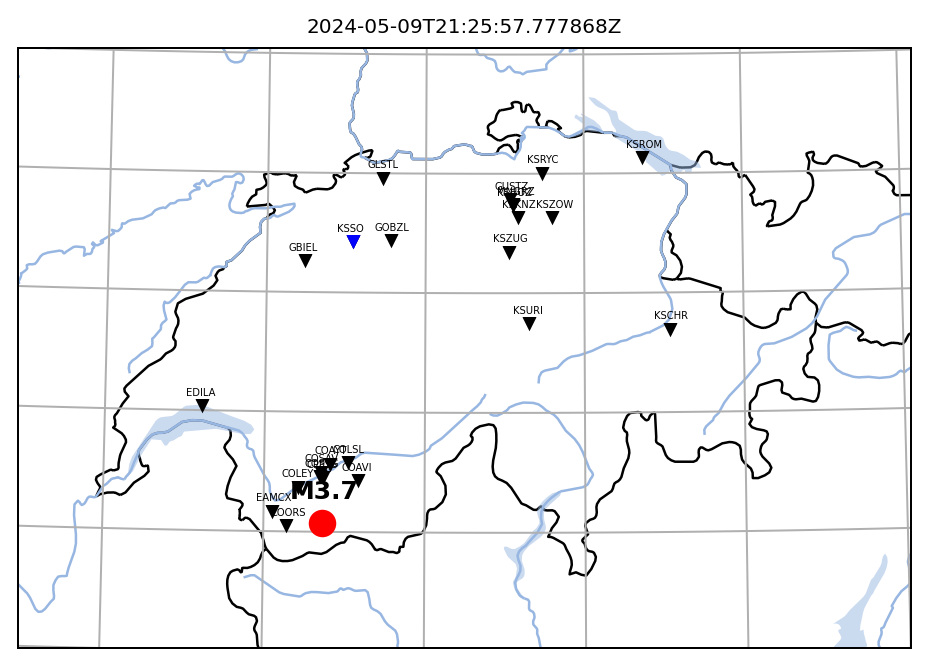

Die P-Wellen (roter Strich) erreichen die Station KSSO nach 23.0 Sekunden, die S-Wellen (blauer Strich) nach 39.8 Sekunden.
Die P-Wellen (roter Strich) erreichen die Station MOUTI nach 24.3 Sekunden, die S-Wellen (blauer Strich) nach 42.1 Sekunden.


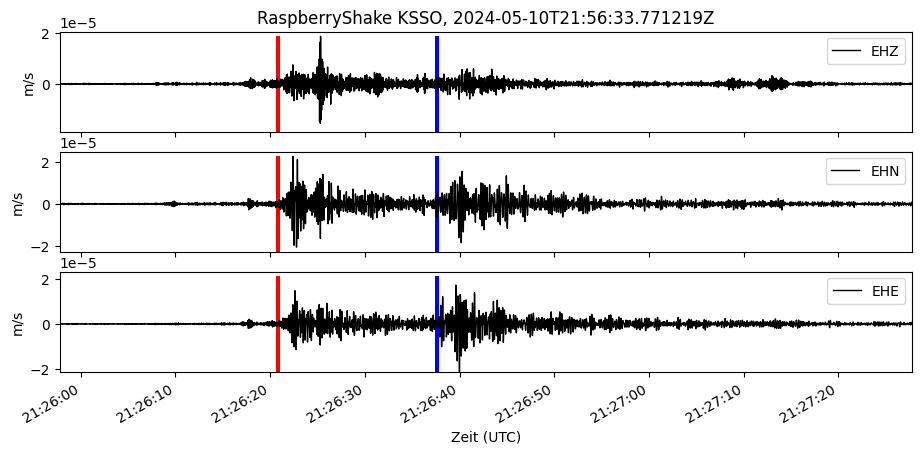

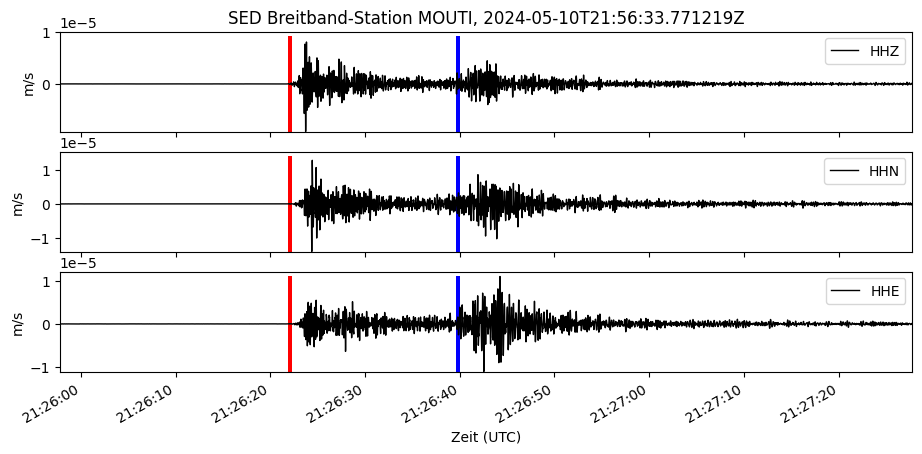

In [10]:
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:

origin_time = cat[function_eqs.value].origins[0].time
eq_lat = cat[function_eqs.value].origins[0].latitude
eq_lon = cat[function_eqs.value].origins[0].longitude
eq_depth = cat[function_eqs.value].origins[0].depth/1000
eq_mag = cat[function_eqs.value].magnitudes[0].mag
print("Das Erdbeben ereignete sich in "+cat[function_eqs.value].event_descriptions[0].text)
#print("Das Erdbeben ereignete sich an Länge = " + str(np.around(eq_lat,decimals=3)) +
#        " Grad und Breite = " + str(np.around(eq_lon,decimals=3)) + " Grad. Es hatte eine Tiefe von " + str(round(eq_depth)) +
#        " km und eine Magnitude von " +str(np.around(eq_mag,decimals=1)) +".")
rs_station = rs_sta_list[function_rs.value]


# Plot map:
fig = plt.figure(dpi=180)
if eq_type=="Schweiz":
    # Set up a custom projection
    projection = ccrs.AlbersEqualArea(
        central_longitude = 8.5,
        central_latitude = 46.5,
    )
    ax = fig.add_subplot(111, projection=projection)
    ax.set_extent((5.5, 11., 45.5, 48))
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
else:
    #Set up a custom projection
    projection = ccrs.PlateCarree()
    ax = fig.add_subplot(111, projection=projection)
    if eq_type == "Europa":
      ax.set_extent((45, -15, 70.,30))
    else:
      ax.set_extent((-180, 180., -90, 90))
    ax.stock_img()

# Draw standard features
ax.gridlines()
ax.coastlines()
ax.set_title(origin_time,fontsize=8)

for inv in inv_s[0]:
    plt.plot(inv.longitude,inv.latitude,'kv',markersize=4,
             transform=ccrs.Geodetic())
    if inv.code == rs_station[0]:
      plt.plot(inv.longitude,inv.latitude,'bv',markersize=4,
               transform=ccrs.Geodetic())
    if eq_type=="Schweiz":
      plt.text(inv.longitude-0.1,inv.latitude+0.04,inv.code,size=4,
               transform=ccrs.Geodetic())

plt.plot(eq_lon,eq_lat,'ro',markersize=10, transform=ccrs.Geodetic())
plt.text(eq_lon-0.2,eq_lat+0.1,'M'+str(np.around(eq_mag,decimals=1)), fontweight="bold",
         transform=ccrs.Geodetic())

plt.show()

# All seismo-at-school RaspberryShake in Switzerland:
#print(inv_s[0])


########## SEISMOGRAMS #################
for sta_idx in [0, 2]:
  try:
    try:
     inv_rs = Client("ETH").get_stations(network="S", station=rs_station[sta_idx],
                                        location="--", channel="EH*", level="RESP",
                                        starttime=origin_time, endtime=origin_time+24*60*60)
    except:
     inv_rs = Client("ETH").get_stations(network="CH", station=rs_station[sta_idx],
                                        location="--", channel="HH*", level="RESP",
                                        starttime=origin_time, endtime=origin_time+24*60*60)

     #inv_rs= Client("RASPISHAKE").get_stations(network="AM", station=rs_station[1],
     #                                    location="00", channel="EH*", level="RESP",
     #                                          starttime=origin_time, endtime=origin_time+24*60*60)
    sta_lat = inv_rs[0][0].latitude
    sta_lon = inv_rs[0][0].longitude
    epi_dist = gps2dist_azimuth(eq_lat, eq_lon, sta_lat, sta_lon)[0]/1000
    if epi_dist <= 110:
      phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=epi_dist/111.111,phase_list=["p","s"])
      p_arr = phase_arrivals[0].time
      s_arr = phase_arrivals[1].time
    elif not model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=epi_dist/111.111,phase_list=["P"]) == []:
     phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                        distance_in_degree=epi_dist/111.111,phase_list=["P"])
     p_arr = phase_arrivals[0].time
     phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                        distance_in_degree=epi_dist/111.111,phase_list=["S"])
     s_arr = phase_arrivals[0].time
    else:
     phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=epi_dist/111.111)
     p_arr = phase_arrivals[0].time
     s_arr = []

    try:
     stream = Client("ETH").get_waveforms(network="S", station=rs_station[sta_idx],
                                         location="--", channel="EH*", starttime=origin_time + timewindow_start - 60,
                                         endtime=origin_time + timewindow_end + 60, attach_response=True)
    except:
      stream = Client("ETH").get_waveforms(network="CH", station=rs_station[sta_idx], location="--", channel="HH*",
                                       starttime = origin_time + timewindow_start - 60, endtime = origin_time + timewindow_end + 60, attach_response = True)
      #stream = Client("RASPISHAKE").get_waveforms(network="AM", station=rs_station[1],
      #                                            location="00", channel="EH*", starttime=origin_time + timewindow_start - 60,
      #                                            endtime=origin_time + timewindow_end + 60, attach_response=True)
    stream.merge(method=0, fill_value='interpolate')
    stream.detrend()
    stream.filter('bandpass',freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)
    stream.remove_response(output='VEL')
    stream.trim(starttime = origin_time + timewindow_start, endtime = origin_time + timewindow_end)

    fig = plt.figure()
    for idx, trace in enumerate(stream):
      if trace.stats.channel == "EHZ" or trace.stats.channel == "HHZ":
        ax = fig.add_subplot(len(stream),1,1)
        if sta_idx == 0:
          plt.title("RaspberryShake " +rs_station[sta_idx] + ", " + str(cat[0].origins[0].time))
        else:
          plt.title("SED Breitband-Station " +rs_station[sta_idx] + ", " + str(cat[0].origins[0].time))
      elif trace.stats.channel == "EHN" or trace.stats.channel == "HHN":
        ax = fig.add_subplot(len(stream),1,2)
      else:
        ax = fig.add_subplot(len(stream),1,3)
      ax.xaxis_date()
      ax.plot(trace.times("matplotlib"), trace.data, "k-", linewidth = 1, label = trace.stats.channel)
      plt.bar(origin_time + p_arr, height =  2 * np.abs(trace.max()), bottom = -np.abs(trace.max()),
            width = (timewindow_end-timewindow_start)/200, align = "center", color = "r")
      if not s_arr == []:
        plt.bar(origin_time + s_arr, height = 2 * np.abs(trace.max()), bottom = -np.abs(trace.max()),
              width = (timewindow_end-timewindow_start)/200, align = "center", color = "b")
      plt.xlim(origin_time + timewindow_start, origin_time + timewindow_end)
      plt.xlabel('Zeit (UTC)')
      plt.ylabel('m/s')
      plt.legend()
      fig.autofmt_xdate()

    fig.set_figheight(5)
    fig.set_figwidth(11)

    print("Die P-Wellen (roter Strich) erreichen die Station " +rs_station[sta_idx]+ " nach " + str(np.around(p_arr,decimals=1)) +
        " Sekunden, die S-Wellen (blauer Strich) nach "+ str(np.around(s_arr,decimals=1)) + " Sekunden.")
  except:
    print("Ich habe keine Daten für "+rs_station[sta_idx]+ " gefunden.")

  #print("Die Daten wurden von " +str(freqmin) + " Hertz (Hz) bis " +str(freqmax) + " Hertz (Hz) gefiltert.")

**SCHRITT 2: Seismogramme von allen seismo-at-school RaspberryShake**

Führe den Code in der nächsten Zelle aus, um die Seismogramme von allen seismo-at-school RaspberryShake in der Schweiz zu sehen.

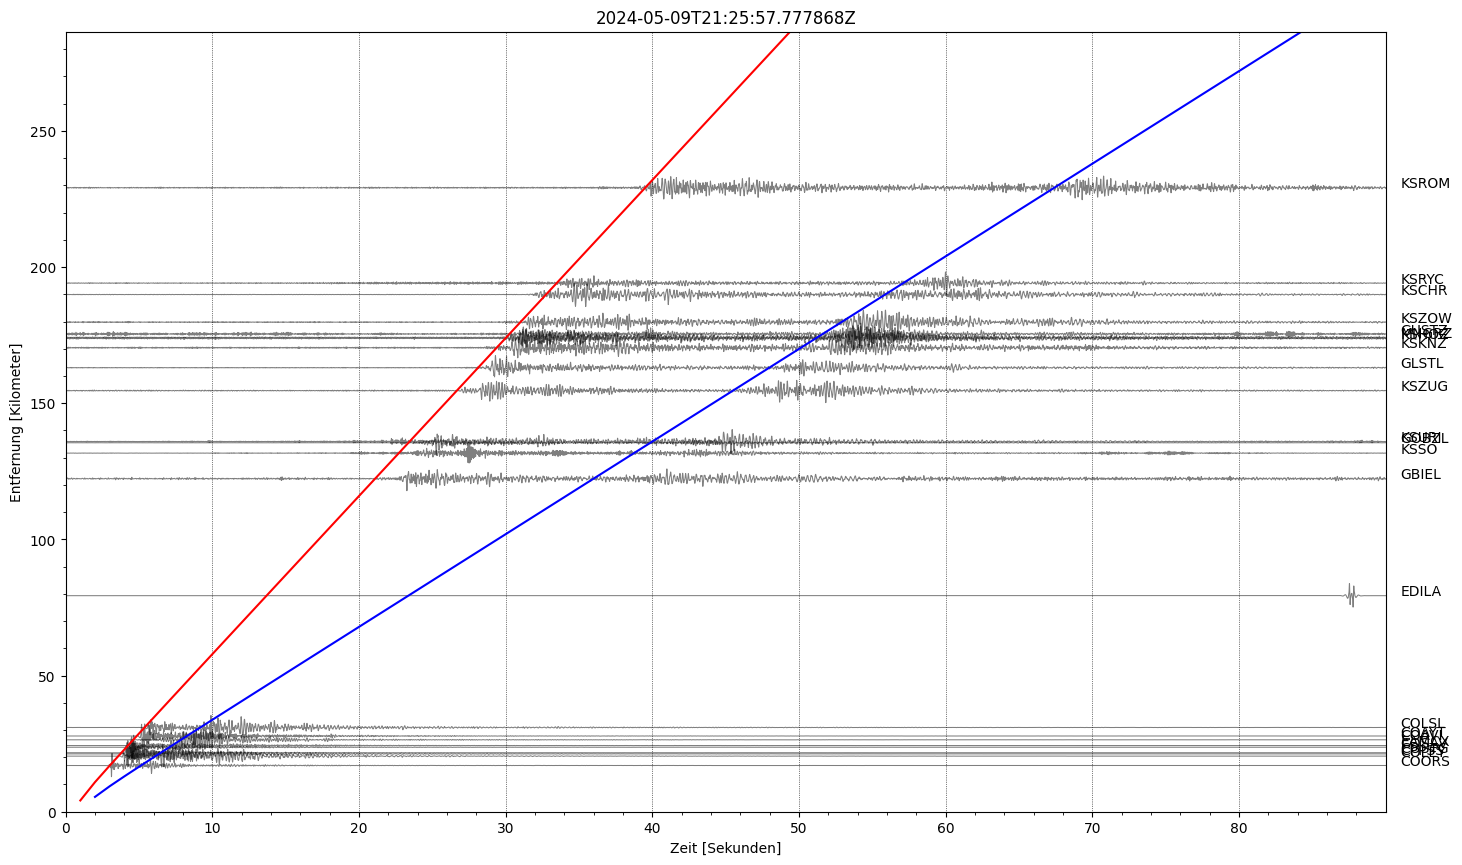

In [8]:
# @title
# Diesen Code solltest Du nicht verändern, ausser wenn Du schon etwas programmieren kannst:


try:
  for network in ["S"]:
    if network == "CH":
      inventory = inv_ch
    else:
      inventory = inv_s
    stream = Stream()
    distance = []
    name = []
    for idx, inv in enumerate(inventory[0]):
      try:
        station = inv.code
        trace = Client("ETH").get_waveforms(network=network, station=station, location="--",
                                            channel="*Z", starttime=origin_time + timewindow_start -60, endtime=origin_time + timewindow_end +60, attach_response=True)
        trace.merge()
        distance.append(gps2dist_azimuth(inv.latitude, inv.longitude, eq_lat, eq_lon)[0])
        name.append(station)
        stream += trace
      except:
        print("Ich habe keine Seismogramme für " +str(station) + " gefunden.")

    stream.remove_response(output='VEL')
    stream.filter('bandpass',freqmin=freqmin, freqmax=freqmax, corners=4, zerophase=True)
    stream.trim(starttime = origin_time, endtime = origin_time + timewindow_end)

    for idx, trace in enumerate(stream):
      trace.stats.distance = distance[idx]
      trace.stats.station = name[idx]

    fig = plt.figure()
    stream.plot(type='section', orientation='horizontal', right_vertical_labels=True,
                linewidth=.75, grid_linewidth=.5, scale=0.75, show=True, fig=fig,
                localization_dict={'Time [s]': 'Zeit [s]', 'Offset [km]': 'Entfernung [km]'})
    fig.set_figheight(10)
    fig.set_figwidth(15)
    plt.title(str(origin_time))

    if min(distance)/1000 < 150:
      time_axis = np.arange(0, int(timewindow_end), 1)
      plt.plot(time_axis,np.sqrt(pow(time_axis * vp,2)-pow(eq_depth,2)),'r') # P-wave
      plt.plot(time_axis,np.sqrt(pow(time_axis * vs,2)-pow(eq_depth,2)),'b') # S-wave
      plt.ylim(0,max(distance) /1000 * 1.25)
    else:
      dist_axis = np.arange(int(min(distance)/1000-50), int(max(distance)/1000+50), 50)
      p_arr = []
      s_arr = []

      for dist in dist_axis:
        if not model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=dist/111.111,phase_list=["P"]) == []:
          phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=dist/111.111,phase_list=["P"])
          p_arr.append([phase_arrivals[0].time, dist])
          phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                          distance_in_degree=dist/111.111,phase_list=["S"])
          s_arr.append([phase_arrivals[0].time, dist])
        else:
          phase_arrivals = model.get_travel_times(source_depth_in_km=max([1.0, eq_depth]),
                                         distance_in_degree=dist/111.111)
          p_arr.append([phase_arrivals[0].time, dist])
          s_arr.append([[], dist])

      plt.plot(np.array(p_arr)[:,0],np.array(p_arr)[:,1],'r-') # P-wave
      if not np.array(s_arr)[0,0] == []:
        plt.plot(np.array(s_arr)[:,0],np.array(s_arr)[:,1],'b-') # S-wave

    for idx, trace in enumerate(stream):
      plt.text(timewindow_end+1, trace.stats.distance /1000, str(trace.stats.station))

    plt.xlabel("Zeit [Sekunden]")
    plt.ylabel("Entfernung [Kilometer]")


except:
  print("Ich habe leider keine Daten gefunden.")

**SCHRITT 3: Wellenausbreitung durch das Erdinnere**

Führe den Code in der nächsten Zelle aus, um zu sehen, welchen Weg die schnellsten Erdbebenwellen, die sogenannten P-Wellen, vom Erdbeben (Stern) bis zu dem RaspberryShake (Dreieck) durch das Erdinnere zurückgelegt haben.

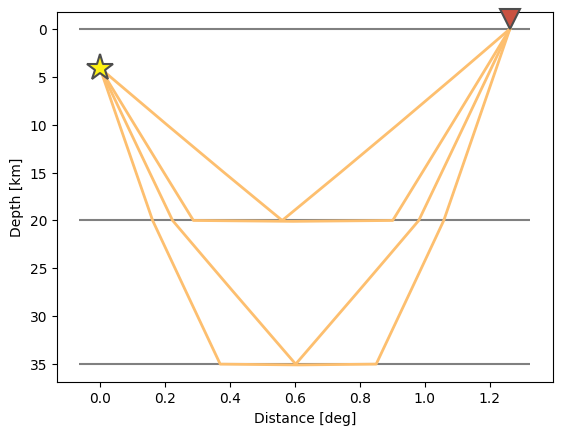

In [9]:
# @title
# Diesen Code solltest Du nicht verändern:

arrivals = model.get_ray_paths(source_depth_in_km=max([1.0, eq_depth]), distance_in_degree=epi_dist/111.111, phase_list=[phase_arrivals[0].name])
if eq_type == "Schweiz" or eq_type == "Europa":
  ax = arrivals.plot_rays(plot_type="cartesian")
else:
  ax = arrivals.plot_rays()

if eq_type=="weltweit":
  print("Neben den direkten P- und S-Wellen gibt es noch viele weitere Erdbebenwellen-Phasen, die durch Refraktion und Reflektion von P- und S-Wellen entstehen.")
  print("Sie breiten sich durch andere Erdschichten aus und erreichen den RasberryShake zu anderen Zeiten.")
  arrivals = model.get_ray_paths(source_depth_in_km=max([1.0, eq_depth]), distance_in_degree=epi_dist/111.111, phase_list=["ttbasic"])
  ax = arrivals.plot_rays()
  print(arrivals)
  print("")
  print("Durch das Picken verschiedener Phasen für viele Erdbeben können Seismologen und Seismologinnen die Geschwindigkeiten verschiedener Gesteinsschichten und den Aufbau der Erde bestimmen.")
